In [47]:
import kagglehub
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS, RandomEffects
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from stargazer.stargazer import Stargazer
from scipy.stats import chi2
import os

pd.options.display.float_format = '{:.2f}'.format

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from linearmodels.iv import IV2SLS

In [ ]:
path = kagglehub.dataset_download("artermiloff/steam-games-dataset")

print("保存先パス:", path)

csv_path = os.path.join(path, "games_march2025_cleaned.csv")

df = pd.read_csv(csv_path, index_col=False, quotechar='"')
df = df.drop(columns=['score_rank'])

pd.set_option('display.max_columns', None)

# pd.reset_option('display.max_columns')

df.head()

保存先パス: /Users/kavuk/.cache/kagglehub/datasets/artermiloff/steam-games-dataset/versions/2


,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,header_image,website,support_url,support_email,windows,mac,linux,metacritic_score,metacritic_url,achievements,recommendations,notes,supported_languages,full_audio_languages,packages,developers,publishers,categories,genres,screenshots,movies,user_score,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent
0,730,Counter-Strike 2,2012-08-21,0,0.00,1,"For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...",NaN,https://shared.akamai.steamstatic.com/store_it...,http://counter-strike.net/,NaN,NaN,True,False,True,0,NaN,1,4401572,Includes intense violence and blood.,"['Czech', 'Danish', 'Dutch', 'English', 'Finni...","['English', 'Indonesian']","[{'title': 'Buy Counter-Strike 2', 'descriptio...",['Valve'],['Valve'],"['Multi-player', 'Cross-Platform Multiplayer',...","['Action', 'Free To Play']",['https://shared.akamai.steamstatic.com/store_...,['http://video.akamai.steamstatic.com/store_tr...,0,7480813,1135108,100000000 - 200000000,33189,879,5174,350,0,1212356,"{'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...",86,8632939,82,96473
1,578080,PUBG: BATTLEGROUNDS,2017-12-21,0,0.00,0,"LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...",Play PUBG: BATTLEGROUNDS for free. Land on str...,NaN,https://shared.akamai.steamstatic.com/store_it...,https://www.pubg.com,https://support.pubg.com/hc/en-us,NaN,True,False,False,0,NaN,37,1732007,NaN,"['English', 'Korean', 'Simplified Chinese', 'F...",[],[],['PUBG Corporation'],"['KRAFTON, Inc.']","['Multi-player', 'PvP', 'Online PvP', 'Stats',...","['Action', 'Adventure', 'Massively Multiplayer...",['https://shared.akamai.steamstatic.com/store_...,[],0,1487960,1024436,50000000 - 100000000,0,0,0,0,0,616738,"{'Survival': 14838, 'Shooter': 12727, 'Battle ...",59,2513842,68,16720
2,570,Dota 2,2013-07-09,0,0.00,2,"The most-played game on Steam. Every day, mill...","The most-played game on Steam. Every day, mill...","Every day, millions of players worldwide enter...",“A modern multiplayer masterpiece.” 9.5/10 – D...,https://shared.akamai.steamstatic.com/store_it...,http://www.dota2.com/,NaN,NaN,True,True,True,90,https://www.metacritic.com/game/pc/dota-2?ftag...,0,14337,"Dota 2 includes fantasy violence, use of alcoh...","['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['English', 'Korean', 'Simplified Chinese', 'V...","[{'title': 'Buy Dota 2', 'description': '', 's...",['Valve'],['Valve'],"['Multi-player', 'Co-op', 'Steam Trading Cards...","['Action', 'Strategy', 'Free To Play']",['https://shared.akamai.steamstatic.com/store_...,['http://video.akamai.steamstatic.com/store_tr...,0,1998462,451338,200000000 - 500000000,43031,1536,898,892,0,555977,"{'Free to Play': 59933, 'MOBA': 20158, 'Multip...",81,2452595,80,29366
3,271590,Grand Theft Auto V Legacy,2015-04-13,17,0.00,0,"When a young street hustler, a retired bank ro...","When a young street hustler, a retired bank ro...",Grand Theft Auto V for PC offers players the o...,NaN,https://shared.akamai.steamstatic.com/store_it...,https://www.rockstargames.com/V/,https://support.rockstargames.com,NaN,True,False,False,96,https://www.metacritic.com/game/pc/grand-theft...,77,1803063,NaN,"['English', 'French', 'Italian', 'German', 'Sp...","['English', 'Spanish - Latin America']","[{'title': 'Buy Shark Cash Cards', 'descriptio...",['Rockstar North'],['Rockstar Games'],"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Action', 'Adventure']",['https://shared.akamai.steamstatic.com/store_...,['http://video.akamai.steamstatic.com/store_tr...,0,1719950,250012,50000000 - 100000000,19323,771,7101,74,0,117698,"{'Open World': 32644, 'Action': 23539, 'M

In [18]:
print(df.columns)

Index(['appid', 'name', 'release_date', 'required_age', 'price', 'dlc_count',
       'detailed_description', 'about_the_game', 'short_description',
       'reviews', 'header_image', 'website', 'support_url', 'support_email',
       'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url',
       'achievements', 'recommendations', 'notes', 'supported_languages',
       'full_audio_languages', 'packages', 'developers', 'publishers',
       'categories', 'genres', 'screenshots', 'movies', 'user_score',
       'positive', 'negative', 'estimated_owners', 'average_playtime_forever',
       'average_playtime_2weeks', 'median_playtime_forever',
       'median_playtime_2weeks', 'discount', 'peak_ccu', 'tags',
       'pct_pos_total', 'num_reviews_total', 'pct_pos_recent',
       'num_reviews_recent'],
      dtype='object')


In [ ]:
df['posi_nega_ratio'] = df['positive'] / (df['negative'] + 1)

df['log_ccu'] = np.log(df['peak_ccu'] + 1)
df['log_positive'] = np.log(df['positive'] + 1)
df['log_negative'] = np.log(df['negative'] + 1)
df['log_median_playtime'] = np.log1p(df['median_playtime_forever'])
df['log_num_reviews_total'] = np.log1p(df['num_reviews_total'])

df['pub_id'] = pd.factorize(df['publishers'])[0]
df['main_genre'] = df['genres'].str.split(',').str[0]

df_100 = df[df['peak_ccu'] >= 100].copy()

df_1000 = df[df['peak_ccu'] >= 1000].copy()

df.sample(n=10)

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,header_image,website,support_url,support_email,windows,mac,linux,metacritic_score,metacritic_url,achievements,recommendations,notes,supported_languages,full_audio_languages,packages,developers,publishers,categories,genres,screenshots,movies,user_score,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent,posi_nega_ratio,log_ccu,log_positive,log_negative,log_median_playtime,log_num_reviews_total,pub_id,main_genre
11893,559960,Power Hover,2017-01-10,0,3.99,0,OVERVIEW Power Hover is an action game about h...,OVERVIEW Power Hover is an action game about h...,"Take control of the hoverboarding robots, expl...",“It is a game that I would have gladly payed m...,https://shared.akamai.steamstatic.com/store_it...,http://www.oddrok.com/powerhover/,http://www.oddrok.com/,info@oddrok.com,True,True,False,0,NaN,12,299,NaN,"['English', 'French', 'Italian', 'German', 'Sp...",[],"[{'title': 'Buy Power Hover', 'description': '...",['ODDROK'],['ODDROK'],"['Single-player', 'Steam Achievements', 'Full ...","['Action', 'Adventure', 'Indie', 'Racing']",['https://shared.akamai.steamstatic.com/store_...,['http://video.akamai.steamstatic.com/store_tr...,0,290,32,20000 - 50000,0,0,0,0,0,0,"{'Racing': 29, 'Adventure': 25, 'Action': 23, ...",89,299,-1,-1,8.79,0.00,5.67,3.50,0.00,5.70,5863,['Action'
51741,1454650,Kanso,2022-01-25,0,4.99,0,"Immerse into a colourfully ambient space, effo...","Immerse into a colourfully ambient space, effo...","Kanso, a beautiful and hyper relaxing line fol...","“a lot of fun and damn, it is so relaxing” Gam...",https://shared.akamai.steamstatic.com/store_it...,http://www.davesapien.com/DaveSapien/kanso.html,http://www.davesapien.com/DaveSapien/kanso.html,Support@davesapien.com,True,False,False,0,NaN,0,0,NaN,"['English', 'French', 'Italian', 'German', 'Sp...",[],"[{'title': 'Buy Kanso', 'description': '', 'su...",['Dave Sapien'],['Dave Sapien'],"['Single-player', 'Full controller support', '...","['Casual', 'Indie']",['https://shared.akamai.steamstatic.com/store_...,['http://video.akamai.steamstatic.com/store_tr...,0,18,0,0 - 20000,0,0,0,0,0,0,"{'Puzzle': 135, 'Relaxing': 129, 'Atmospheric'...",100,10,-1,-1,18.00,0.00,2.94,0.00,0.00,2.40,26722,['Casual'
15307,2194610,Hero Roy's Wedding,2022-12-28,0,6.99,0,"As the Hero that saved the world, Roy is the d...","As the Hero that saved the world, Roy is the d...","You will act as Roy, spending a month dating t...",NaN,https://shared.akamai.steamstatic.com/store_it...,NaN,https://www.facebook.com/swordrp.swordrp.5,swordrp5@gmail.com,True,False,False,0,NaN,10,177,"This game has a certain amount of nudity, inde...","['Simplified Chinese', 'English', 'Traditional...",[],"[{'title': ""Buy Hero Roy's Wedding"", 'descript...",['SwordRP5'],['TWODOG'],"['Single-player', 'Family Sharing']","['Casual', 'Indie', 'RPG']",['https://shared.akamai.steamstatic.com/store_...,['http://video.akamai.steamstatic.com/store_tr...,0,0,0,0 - 20000,0,0,0,0,0,2,[],75,179,-1,-1,0.00,1.10,0.00,0.00,0.00,5.19,7524,['Casual'
54801,2206180,Show Ball: Tiger Life,2022-11-18,0,2.99,0,Enjoy A Real Show With Show Ball: Tiger Life! ...,Enjoy A Real Show With Show Ball: Tiger Life! ...,Show Ball: Tiger Life is a challenge where you...,NaN,https://shared.akamai.steamstatic.com/store_it...,NaN,https://twitter.com/PigeonG_games,pigeong.correo@info.com,True,False,False,0,NaN,28,0,NaN,"['English', 'French', 'Italian', 'German', 'Sp...","['English', 'French', 'Italian', 'German', 'Sp...","[{'title': 'Buy Show Ball: Tiger Life', 'descr...",['Pigeon-G'],['Pigeon-G'],"['Single-player', 'Steam Achievements', 'Famil...","['Adventure', 'Casual', 'Indie', 'Strategy']",['https://shared.akamai.steamstatic.com/store_...,['http://video.akamai.steamstatic.com/sto

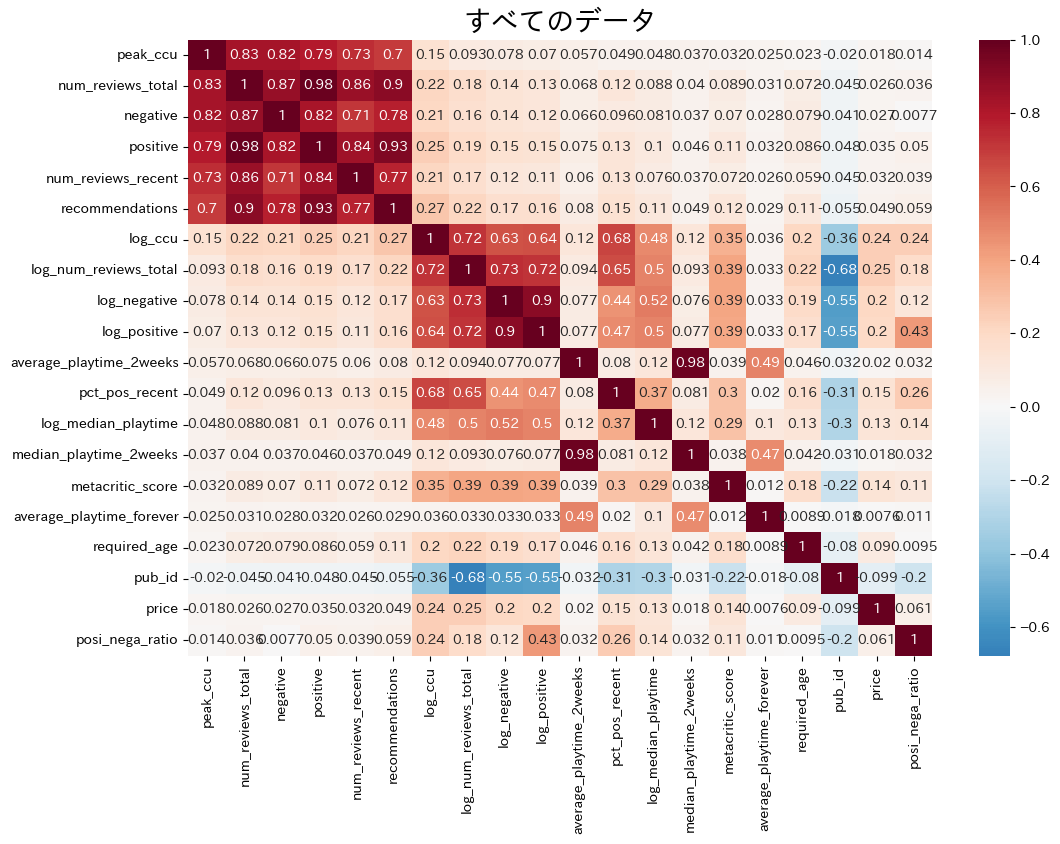

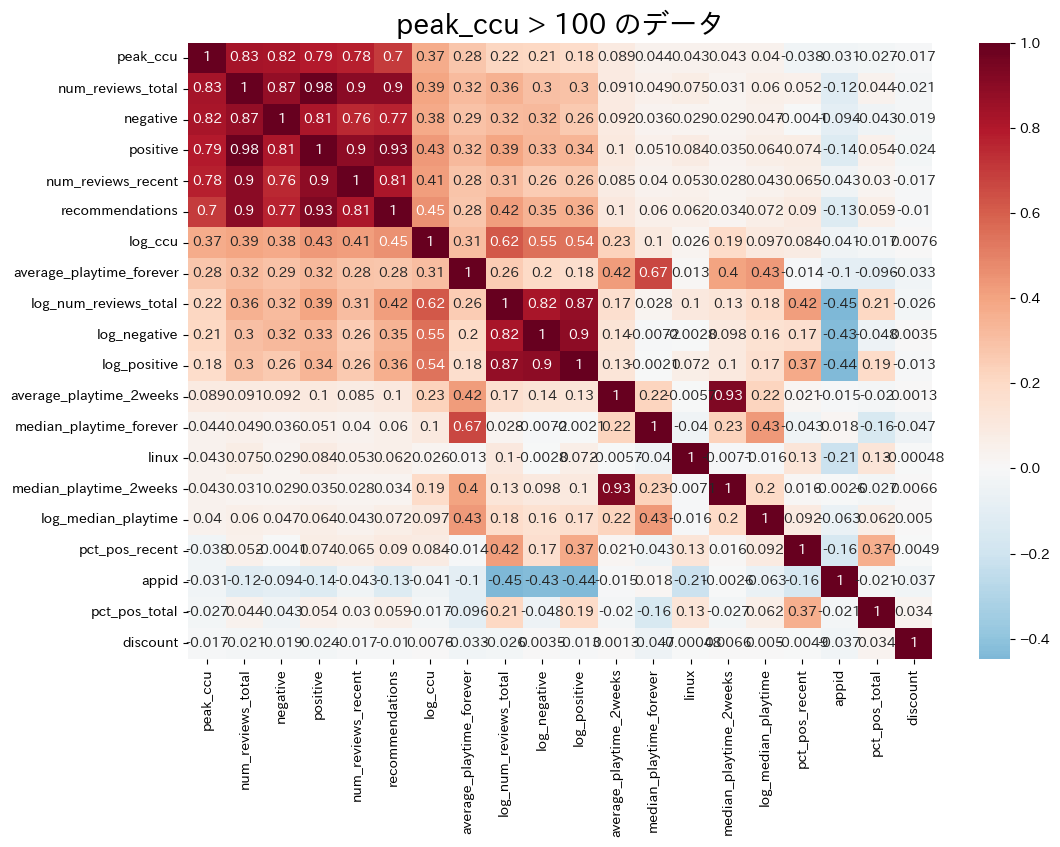

In [20]:
top_corr_cols = df.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
plt.title('すべてのデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

top_corr_cols = df_100.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
top_corr_matrix = df_100[top_corr_cols].corr()

plt.figure(figsize=(12, 8))
plt.title('peak_ccu > 100 のデータ', size=20)  # 図のタイトル   size=は省略可能
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.show()

# top_corr_cols = df_1000.corr(numeric_only=True)['peak_ccu'].abs().sort_values(ascending=False).head(20).index
# top_corr_matrix = df_1000[top_corr_cols].corr()

# plt.figure(figsize=(12, 8))
# plt.title('peak_ccu > 1000 のデータ', size=20)  # 図のタイトル   size=は省略可能
# sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', center=0)
# plt.show()

In [21]:
zero_count = (df['peak_ccu'] == 0).sum()
print(f"同時接続ゼロのゲーム数: {zero_count} / 全体: {len(df)}")

print(f"log_ccu の最大値: {df['log_ccu'].max()}")

同時接続ゼロのゲーム数: 70698 / 全体: 89618
log_ccu の最大値: 14.008076956694195


In [22]:
all_models = []
formula = "peak_ccu ~ positive"
mod = smf.ols(formula, data=df_100)
res = mod.fit()
all_models.append(res)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               peak_ccu   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     3441.
Date:                Thu, 26 Feb 2026   Prob (F-statistic):               0.00
Time:                        17:12:09   Log-Likelihood:                -23403.
No. Observations:                2042   AIC:                         4.681e+04
Df Residuals:                    2040   BIC:                         4.682e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2385.6276    520.877     -4.580      0.0

In [23]:
formula = "log_ccu ~ log_positive"
mod = smf.ols(formula, data=df_100)
res = mod.fit()
all_models.append(res)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     835.3
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          3.03e-154
Time:                        17:12:09   Log-Likelihood:                -3331.8
No. Observations:                2042   AIC:                             6668.
Df Residuals:                    2040   BIC:                             6679.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.9505      0.119     24.759   

In [24]:
formula = "log_ccu ~ log_negative"
mod = smf.ols(formula, data=df_100)
res = mod.fit()
all_models.append(res)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     890.0
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          1.34e-162
Time:                        17:12:09   Log-Likelihood:                -3312.6
No. Observations:                2042   AIC:                             6629.
Df Residuals:                    2040   BIC:                             6640.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.4064      0.101     33.795   

In [25]:
print(f"現在 {len(all_models)} 個のモデルが溜まっています")
st = Stargazer(all_models)
st.custom_columns([f"Model {i+1}" for i in range(len(all_models))], [1]*len(all_models))
st

現在 3 個のモデルが溜まっています


In [26]:
df_100 = df_100.dropna(subset=['publishers'])
# 1. シンプルにユニークな名前の数を見る
print(f"ユニークなパブリッシャー数: {df_100['publishers'].nunique()}")

# 2. 出版数ランキング（被り＝同じパブリッシャーが複数のゲームを出しているか）
publisher_counts = df_100['publishers'].value_counts()
print(publisher_counts.head(20)) # 上位20社を表示

# 3. 1つしかゲームを出していないパブリッシャーがどれくらいいるか
single_game_pubs = (publisher_counts == 1).sum()
print(f"1作品しか出していないパブリッシャー数: {single_game_pubs}")

ユニークなパブリッシャー数: 1147
publishers
['Electronic Arts']               50
['Ubisoft']                       47
['SEGA']                          46
['Square Enix']                   34
['KOEI TECMO GAMES CO., LTD.']    28
['Xbox Game Studios']             27
['Bethesda Softworks']            25
['THQ Nordic']                    25
['CAPCOM Co., Ltd.']              23
['Activision']                    20
['Focus Entertainment']           18
['Paradox Interactive']           17
['2K']                            17
['Nacon']                         16
['PlayStation Publishing LLC']    16
['Deep Silver']                   14
['Bandai Namco Entertainment']    14
['Team17']                        13
['Rockstar Games']                11
['Devolver Digital']              10
Name: count, dtype: int64
1作品しか出していないパブリッシャー数: 927


In [27]:
# 1. 検定用データの作成（CCU100以上のデータを使用）
# 必要な変数に欠損値がある行をあらかじめ削除
df_hm = df_100.dropna(subset=['pub_id', 'log_ccu', 'log_positive', 'log_negative', 'price']).copy()

# パブリッシャーIDを「個体」、appidを「時間/観測単位」としてインデックス設定
# これにより linearmodels がパネル構造を認識する
df_hm = df_hm.set_index(['pub_id', 'appid'])

# 2. 固定効果モデル (Fixed Effects)
# EntityEffects=True がパブリッシャー固定効果を意味する
mod_fe = PanelOLS.from_formula("log_ccu ~ log_positive + log_negative + price + EntityEffects", data=df_hm)
res_fe = mod_fe.fit()

# 3. ランダム効果モデル (Random Effects)
mod_re = RandomEffects.from_formula("log_ccu ~ log_positive + log_negative + price", data=df_hm)
res_re = mod_re.fit()

# 4. ハウスマン検定関数の実行
def perform_hausman(fe, re):
    b_fe = fe.params
    b_re = re.params
    v_fe = fe.cov
    v_re = re.cov
    
    # 定数項以外で共通する係数を抽出
    common_idx = [i for i in b_fe.index if i in b_re.index]
    
    b_diff = np.atleast_2d(b_fe[common_idx] - b_re[common_idx])
    cov_diff = v_fe.loc[common_idx, common_idx] - v_re.loc[common_idx, common_idx]
    
    stat = abs(np.dot(np.dot(b_diff, np.linalg.inv(cov_diff)), b_diff.T).item())
    df = len(common_idx)
    p_val = 1 - chi2.cdf(stat, df)
    
    print("--- Hausman Test Results ---")
    print(f"Chi-squared statistic: {stat:.4f}")
    print(f"Degrees of freedom: {df}")
    print(f"p-value: {p_val:.4f}")
    
    if p_val < 0.05:
        print("結論: p < 0.05 なのでランダム効果モデルを棄却。固定効果モデル(FE)を採用すべきです。")
    else:
        print("結論: p >= 0.05 なのでランダム効果モデル(RE)を排除できません。")

perform_hausman(res_fe, res_re)

--- Hausman Test Results ---
Chi-squared statistic: 27.3482
Degrees of freedom: 3
p-value: 0.0000
結論: p < 0.05 なのでランダム効果モデルを棄却。固定効果モデル(FE)を採用すべきです。


In [28]:
#LSDV
model_fe = smf.ols("log_ccu ~ log_positive + price + C(pub_id) + C(main_genre)", data=df_100).fit()
print(model_fe.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     2.144
Date:                Thu, 26 Feb 2026   Prob (F-statistic):           7.18e-32
Time:                        17:12:11   Log-Likelihood:                -2296.5
No. Observations:                2042   AIC:                             6937.
Df Residuals:                     870   BIC:                         1.353e+04
Df Model:                        1171                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [29]:
def run_model(formula, data= df_100):
    mod = smf.ols(formula, data = data)
    res = mod.fit()
    all_models.append(res)
    return print(res.summary())

In [30]:
all_models = []
formula = "log_ccu ~ log_positive + log_negative"
run_model(formula)

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     467.1
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          9.84e-168
Time:                        17:12:11   Log-Likelihood:                -3297.1
No. Observations:                2042   AIC:                             6600.
Df Residuals:                    2039   BIC:                             6617.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.0586      0.118     25.943   

In [31]:
formula = "log_ccu ~ log_positive + log_negative + posi_nega_ratio"
run_model(formula)

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     324.8
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          2.48e-172
Time:                        17:12:11   Log-Likelihood:                -3283.3
No. Observations:                2042   AIC:                             6575.
Df Residuals:                    2038   BIC:                             6597.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.1841      0.120     

In [32]:
formula = "log_ccu ~ log_positive + log_negative + price"
run_model(formula)

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     313.9
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          1.68e-167
Time:                        17:12:11   Log-Likelihood:                -3294.5
No. Observations:                2042   AIC:                             6597.
Df Residuals:                    2038   BIC:                             6619.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.0140      0.119     25.255   

In [33]:
formula = "log_ccu ~ log_positive + log_negative + price + log_median_playtime"
run_model(formula)

                            OLS Regression Results                            
Dep. Variable:                log_ccu   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     235.3
Date:                Thu, 26 Feb 2026   Prob (F-statistic):          3.23e-166
Time:                        17:12:11   Log-Likelihood:                -3294.4
No. Observations:                2042   AIC:                             6599.
Df Residuals:                    2037   BIC:                             6627.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.0132    

In [34]:
st = Stargazer(all_models)
st.custom_columns([f"Model {i+1}" for i in range(len(all_models))], [1]*len(all_models))
st

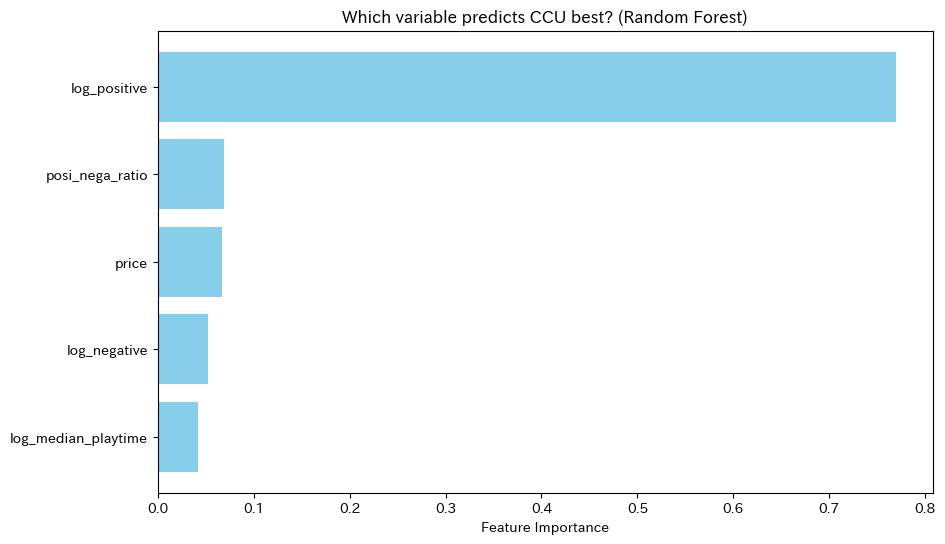

               Feature  Importance
0         log_positive        0.77
2      posi_nega_ratio        0.07
4                price        0.07
1         log_negative        0.05
3  log_median_playtime        0.04


In [35]:
# 1. 特徴量（X）と目的変数（y）の準備
# 昨日の変数をベースに、欠損値がある場合は落とす
features = ['log_positive', 'log_negative', 'posi_nega_ratio', 'log_median_playtime', 'price']
df_ml = df[features + ['log_ccu']].dropna()

X = df_ml[features]
y = df_ml['log_ccu']

# 2. モデルの構築と学習
# n_estimators: 作成する樹の数
# random_state: 結果を固定
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# 3. 特徴量の重要度（Feature Importance）の抽出
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. 可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Which variable predicts CCU best? (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)

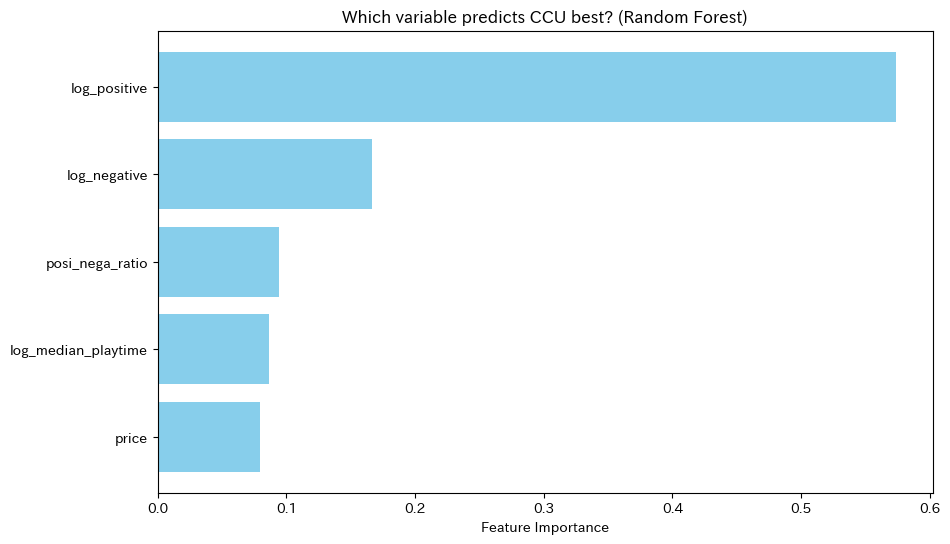

               Feature  Importance
0         log_positive        0.57
1         log_negative        0.17
2      posi_nega_ratio        0.09
3  log_median_playtime        0.09
4                price        0.08


In [36]:
# 1. 特徴量（X）と目的変数（y）の準備
# 昨日の変数をベースに、欠損値がある場合は落とす
features = ['log_positive', 'log_negative', 'posi_nega_ratio', 'log_median_playtime', 'price']
df_ml = df_100[features + ['log_ccu']].dropna()

X = df_ml[features]
y = df_ml['log_ccu']

# 2. モデルの構築と学習
# n_estimators: 作成する樹の数
# random_state: 結果を固定
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# 3. 特徴量の重要度（Feature Importance）の抽出
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. 可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Which variable predicts CCU best? (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)

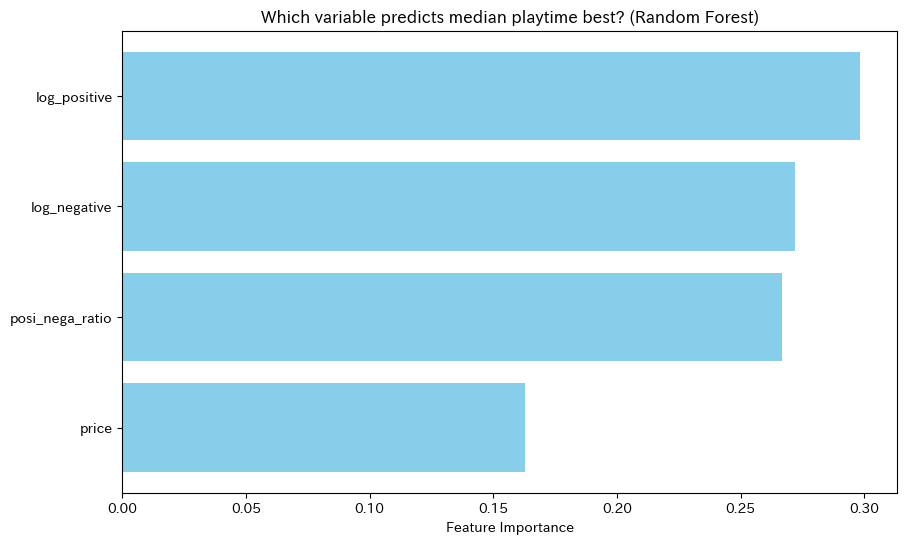

           Feature  Importance
0     log_positive        0.30
1     log_negative        0.27
2  posi_nega_ratio        0.27
3            price        0.16


In [37]:
# 1. 特徴量（X）と目的変数（y）の準備
# 昨日の変数をベースに、欠損値がある場合は落とす
features = ['log_positive', 'log_negative', 'posi_nega_ratio', 'price']
df_ml = df_100[features + ['log_median_playtime']].dropna()

X = df_ml[features]
y = df_ml['log_median_playtime']

# 2. モデルの構築と学習
# n_estimators: 作成する樹の数
# random_state: 結果を固定
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# 3. 特徴量の重要度（Feature Importance）の抽出
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. 可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Which variable predicts median playtime best? (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)

In [38]:
# 1. データの準備
# T: Treatment (原因), Y: Outcome (結果), X: Nuisance (邪魔な変数)
T = df_100['log_positive']
Y = df_100['log_ccu']
X = df_100[['price', 'log_median_playtime', 'log_negative']] # その他交絡因子

# --- 第1段階: Nuisance Model (力技での掃除) ---

# (a) Tの残差化: 他の変数からT(高評価数)を予測し、予測できない「純粋なT」を取り出す
model_t = RandomForestRegressor(n_estimators=100, random_state=42)
model_t.fit(X, T)
T_res = T - model_t.predict(X)

# (b) Yの残差化: 他の変数からY(CCU)を予測し、予測できない「純粋なY」を取り出す
model_y = RandomForestRegressor(n_estimators=100, random_state=42)
model_y.fit(X, Y)
Y_res = Y - model_y.predict(X)

# --- 第2段階: Causal Estimation (理論による推定) ---

# (c) 残差同士をぶつける (OLS)
# これが「直交化されたモーメント条件」を解くことに相当する
final_model = sm.OLS(Y_res, T_res).fit()

print(final_model.summary())
print(f"因果効果 (theta): {final_model.params[0]:.4f}")

                                 OLS Regression Results                                
Dep. Variable:                log_ccu   R-squared (uncentered):                   0.086
Model:                            OLS   Adj. R-squared (uncentered):              0.086
Method:                 Least Squares   F-statistic:                              193.0
Date:                Thu, 26 Feb 2026   Prob (F-statistic):                    5.52e-42
Time:                        17:12:31   Log-Likelihood:                         -1088.8
No. Observations:                2042   AIC:                                      2180.
Df Residuals:                    2041   BIC:                                      2185.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

/var/folders/wz/q14n80j54sv99s44f_fx2gmh0000gn/T/ipykernel_39282/3999606738.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"因果効果 (theta): {final_model.params[0]:.4f}")


In [39]:
# 1. データの準備
# T: Treatment (原因), Y: Outcome (結果), X: Nuisance (邪魔な変数)
T = df_100['log_negative']
Y = df_100['log_ccu']
X = df_100[['price', 'log_median_playtime', 'log_positive']] # その他交絡因子

# --- 第1段階: Nuisance Model (力技での掃除) ---

# (a) Tの残差化: 他の変数からT(高評価数)を予測し、予測できない「純粋なT」を取り出す
model_t = RandomForestRegressor(n_estimators=100, random_state=42)
model_t.fit(X, T)
T_res = T - model_t.predict(X)

# (b) Yの残差化: 他の変数からY(CCU)を予測し、予測できない「純粋なY」を取り出す
model_y = RandomForestRegressor(n_estimators=100, random_state=42)
model_y.fit(X, Y)
Y_res = Y - model_y.predict(X)

# --- 第2段階: Causal Estimation (理論による推定) ---

# (c) 残差同士をぶつける (OLS)
# これが「直交化されたモーメント条件」を解くことに相当する
final_model = sm.OLS(Y_res, T_res).fit()

print(final_model.summary())
print(f"因果効果 (theta): {final_model.params[0]:.4f}")

                                 OLS Regression Results                                
Dep. Variable:                log_ccu   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              31.08
Date:                Thu, 26 Feb 2026   Prob (F-statistic):                    2.80e-08
Time:                        17:12:32   Log-Likelihood:                         -1079.1
No. Observations:                2042   AIC:                                      2160.
Df Residuals:                    2041   BIC:                                      2166.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

/var/folders/wz/q14n80j54sv99s44f_fx2gmh0000gn/T/ipykernel_39282/2939680452.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"因果効果 (theta): {final_model.params[0]:.4f}")


In [40]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from linearmodels.iv import IV2SLS

# 1. 前処理：CCU 100以上、かつ必要なカラムの欠損値を除去
df_iv = df_100.dropna(subset=['log_ccu', 'log_positive', 'log_positive', 'price']).copy()

# 変数の定義
Y_col = 'log_ccu'
T_col = 'log_positive'
X_cols = ['log_negative', 'log_median_playtime', 'price']
# IV候補（ラグ変数やシステム的な変数などを大量に入れる）
Z_candidates = ['log_positive'] 

# --- STEP 1: LASSOによるIVスクリーニング (Relevance Check) ---
print("Running LASSO for IV screening...")
scaler = StandardScaler()
Z_scaled = scaler.fit_transform(df_iv[Z_candidates])

# LassoCVで最適な正規化パラメータを自動選択
lasso = LassoCV(cv=5, random_state=42).fit(Z_scaled, df_iv[T_col])

# 係数が0でない変数（精鋭IV）を抽出
selected_ivs = [Z_candidates[i] for i, coef in enumerate(lasso.coef_) if coef != 0]
print(f"Selected IVs (Relevant): {selected_ivs}")

if not selected_ivs:
    raise ValueError("LASSOが全てのIV候補を削りました。候補変数を再検討してください。")

# --- STEP 2: IV-DML (Double Machine Learning with IV) ---
def get_residuals(X, target):
    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X, target)
    return target - model.predict(X)

print("Calculating residuals for DML...")
res_Y = get_residuals(df_iv[X_cols], df_iv[Y_col])
res_T = get_residuals(df_iv[X_cols], df_iv[T_col])

# 選定された各IVについて残差を計算
res_Z = pd.DataFrame({
    z: get_residuals(df_iv[X_cols], df_iv[z]) for z in selected_ivs
})

# --- STEP 3: 残差を用いた2SLS推定 ---
# 構造: Outcome(res_Y) ~ [Treatment(res_T) ~ Instruments(res_Z)]
final_iv_model = IV2SLS(res_Y, None, res_T, res_Z).fit()

print("\n--- IV-DML Results ---")
print(final_iv_model.summary)

# J検定（過剰識別制約検定）の確認
if len(selected_ivs) > 1:
    print(f"\nSargan-Hansen J-test p-value: {final_iv_model.sargan.pvalue:.4f}")

Running LASSO for IV screening...
Selected IVs (Relevant): ['log_positive']
Calculating residuals for DML...

--- IV-DML Results ---
                          IV-2SLS Estimation Summary                          
Dep. Variable:                log_ccu   R-squared:                      0.0759
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0755
No. Observations:                2042   F-statistic:                    134.46
Date:                Thu, Feb 26 2026   P-value (F-stat)                0.0000
Time:                        17:12:33   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------

In [41]:
path = kagglehub.dataset_download("artermiloff/steam-games-dataset")

print("保存先パス:", path)

csv_path_2024 = os.path.join(path, "games_may2024_cleaned.csv")

df_2024 = pd.read_csv(csv_path_2024, index_col=False, quotechar='"')

df_2024 = df_2024.drop(columns=['score_rank'])

df_2024.head()

保存先パス: /Users/kavuk/.cache/kagglehub/datasets/artermiloff/steam-games-dataset/versions/2


,AppID,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,header_image,website,support_url,support_email,windows,mac,linux,metacritic_score,metacritic_url,achievements,recommendations,notes,supported_languages,full_audio_languages,packages,developers,publishers,categories,genres,screenshots,movies,user_score,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent
0,730,Counter-Strike 2,2012-08-21,0,0.00,1,"For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://counter-strike.net/,NaN,NaN,True,False,True,0,NaN,1,4111974,Includes intense violence and blood.,"['Czech', 'Danish', 'Dutch', 'English', 'Finni...","['English', 'Vietnamese']","[{'title': 'Buy Counter-Strike 2', 'descriptio...",['Valve'],['Valve'],"['Multi-player', 'Cross-Platform Multiplayer',...","['Action', 'Free to Play']",['https://cdn.akamai.steamstatic.com/steam/app...,['http://cdn.akamai.steamstatic.com/steam/apps...,0,7024836,1029779,100000000 - 200000000,29018,753,6078,352,1362469,"{'FPS': 90076, 'Shooter': 64786, 'Multiplayer'...",87,8071426,80,56072
1,578080,PUBG: BATTLEGROUNDS,2017-12-21,0,0.00,0,"LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...",Play PUBG: BATTLEGROUNDS for free. Land on str...,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://www.pubg.com,https://support.playbattlegrounds.com,NaN,True,False,False,0,NaN,37,1701431,NaN,"['English', 'Korean', 'Simplified Chinese', 'F...",[],[],"['KRAFTON, Inc.']","['KRAFTON, Inc.']","['Multi-player', 'PvP', 'Online PvP', 'Stats',...","['Action', 'Adventure', 'Massively Multiplayer...",['https://cdn.akamai.steamstatic.com/steam/app...,['http://cdn.akamai.steamstatic.com/steam/apps...,0,1379580,981860,50000000 - 100000000,0,0,0,0,590582,"{'Survival': 14611, 'Shooter': 12477, 'Battle ...",58,2365012,68,19517
2,570,Dota 2,2013-07-09,0,0.00,2,"The most-played game on Steam. Every day, mill...","The most-played game on Steam. Every day, mill...","Every day, millions of players worldwide enter...",“A modern multiplayer masterpiece.” 9.5/10 – D...,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.dota2.com/,NaN,NaN,True,True,True,90,https://www.metacritic.com/game/pc/dota-2?ftag...,0,14329,NaN,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...","['English', 'Korean', 'Simplified Chinese', 'V...","[{'title': 'Buy Dota 2', 'description': '', 's...",['Valve'],['Valve'],"['Multi-player', 'Co-op', 'Steam Trading Cards...","['Action', 'Strategy', 'Free to Play']",['https://cdn.akamai.steamstatic.com/steam/app...,['http://cdn.akamai.steamstatic.com/steam/apps...,0,1832477,406030,200000000 - 500000000,35557,1327,1163,977,668192,"{'Free to Play': 59559, 'MOBA': 19966, 'Multip...",81,2247365,71,23832
3,271590,Grand Theft Auto V,2015-04-13,17,0.00,1,"When a young street hustler, a retired bank ro...","When a young street hustler, a retired bank ro...",Grand Theft Auto V for PC offers players the o...,NaN,https://shared.akamai.steamstatic.com/store_it...,http://www.rockstargames.com/V/,https://support.rockstargames.com,NaN,True,False,False,96,https://www.metacritic.com/game/pc/grand-theft...,77,1641404,NaN,"['English', 'French', 'Italian', 'German', 'Sp...","['English', 'Spanish - Latin America']","[{'title': 'Buy Shark Cash Cards', 'descriptio...",['Rockstar North'],['Rockstar Games'],"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Action', 'Adventure']",['https://shared.akamai.steamstatic.com/store_...,['http://cdn.akamai.steamstatic.com/steam/apps...,0,1557234,236827,50000000 - 100000000,12898,590,6910,235,133571,"{'Open World': 31998, 'Action': 23177, 'Multip...",87,1643791,9

In [42]:
import pandas as pd
from linearmodels.iv import IV2SLS

# --- 1. 2024年データの整形 ---
# 2026年側のデータと重複しないよう、必要な列だけ抽出して名前を変える
# AppIDは結合キー、Positiveは1期前のIV候補として使用
df_2024_subset = df_2024[['AppID', 'positive']].copy()
df_2024_subset = df_2024_subset.rename(columns={'positive': 'lag_positive', 'AppID': 'appid'})

# --- 2. 2026年データとAppIDで結合 (Self-Merge) ---
# df_2026 は現在あなたが分析に使っている最新のデータフレーム
df_panel = pd.merge(df, df_2024_subset, on='appid', how='inner')
df_panel['log_lag_positive'] = np.log1p(df_panel['lag_positive'])

# --- 1. データの準備（前述のパネルデータ df_panel を使用） ---
# DML版と同じサンプルで比較するため、欠損値などを揃える
df_iv = df_panel.copy()

# --- 2. モデルの定式化 ---
# 依存変数: log_ccu
# 定数項: 1 (必須)
# 外生共変量: price, log_negative, log_median_playtime
# 内生変数: log_positive
# 操作変数: log_lag_positive, num_reviews_total

# 伝統的なモデルでは、全ての変数を一つの式に並べる
# log_ccu ~ 1 + price + log_negative + log_median_playtime + [log_positive ~ log_lag_positive + num_reviews_total]

# 1(定数項)を追加
df_iv['const'] = 1

# --- 3. 2SLS推定の実行 ---
# IV2SLS(dependent, exog, endog, instruments)
standard_2sls = IV2SLS(
    dependent=df_iv['log_ccu'],
    exog=df_iv[['const', 'price', 'log_negative', 'log_median_playtime']],
    endog=df_iv['log_positive'],
    instruments=df_iv[['log_lag_positive', 'num_reviews_total']]
).fit(cov_type='robust')

print("--- Standard 2SLS Results (Linear Baseline) ---")
print(standard_2sls.summary)

# J検定（過剰識別制約検定）の確認
if len(selected_ivs) > 1:
    print(f"\nSargan-Hansen J-test p-value: {standard_2sls.sargan.pval:.4f}")

--- Standard 2SLS Results (Linear Baseline) ---
                          IV-2SLS Estimation Summary                          
Dep. Variable:                log_ccu   R-squared:                      0.4821
Estimator:                    IV-2SLS   Adj. R-squared:                 0.4821
No. Observations:               74736   F-statistic:                 1.415e+04
Date:                Thu, Feb 26 2026   P-value (F-stat)                0.0000
Time:                        17:12:39   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                                  Parameter Estimates                                  
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
const                  -0.4580     0.0089    -51.582    

In [43]:
# 1. データの条件をDML版と統一する (CCU 100以上)
df_baseline = df_panel[df_panel['peak_ccu'] >= 100].copy()
df_baseline['const'] = 1

# 2. モデルの実行
# IVから 'num_reviews_total' を削除し、'log_lag_positive' だけにする
standard_2sls_clean = IV2SLS(
    dependent=df_baseline['log_ccu'],
    exog=df_baseline[['const', 'price', 'log_negative', 'log_median_playtime']],
    endog=df_baseline['log_positive'],
    instruments=df_baseline[['log_lag_positive']]
).fit(cov_type='robust')

print("--- Cleaned Standard 2SLS Results (Exactly Identified) ---")
print(standard_2sls_clean.summary)

--- Cleaned Standard 2SLS Results (Exactly Identified) ---
                          IV-2SLS Estimation Summary                          
Dep. Variable:                log_ccu   R-squared:                      0.3784
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3769
No. Observations:                1763   F-statistic:                    386.02
Date:                Thu, Feb 26 2026   P-value (F-stat)                0.0000
Time:                        17:12:39   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                                  Parameter Estimates                                  
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
const                   2.2652     0.2292    

In [44]:
# --- 1. 2024年データの整形 ---
# 2026年側のデータと重複しないよう、必要な列だけ抽出して名前を変える
# AppIDは結合キー、Positiveは1期前のIV候補として使用
df_2024_subset = df_2024[['AppID', 'positive']].copy()
df_2024_subset = df_2024_subset.rename(columns={'positive': 'lag_positive', 'AppID': 'appid'})

# --- 2. 2026年データとAppIDで結合 (Self-Merge) ---
# df_2026 は現在あなたが分析に使っている最新のデータフレーム
df_panel = pd.merge(df, df_2024_subset, on='appid', how='inner')

# CCU100以上の絞り込みと対数変換（すでに済んでいる場合はスキップ）
df_panel = df_panel[df_panel['peak_ccu'] >= 100].copy()
df_panel['log_lag_positive'] = np.log1p(df_panel['lag_positive'])

# --- 3. LASSOによるIVスクリーニング ---
# ここで 'log_positive' (2026年) を Z_candidates から外すのが鉄則
Z_candidates = ['log_lag_positive', 'num_reviews_total'] 
print(f"現在、LASSOに投入するIV候補: {Z_candidates}")
T_col = 'log_positive'
Y_col = 'log_ccu'
X_cols = ['price', 'log_negative', 'log_median_playtime']

print("Running LASSO on lagged instruments...")
scaler = StandardScaler()
Z_scaled = scaler.fit_transform(df_panel[Z_candidates])
lasso = LassoCV(cv=5, random_state=42).fit(Z_scaled, df_panel[T_col])

selected_ivs = [Z_candidates[i] for i, coef in enumerate(lasso.coef_) if coef != 0]
print(f"Selected IVs: {selected_ivs}")

# --- 4. IV-DML 実行 ---
def get_residuals(X, target):
    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X, target)
    return target - model.predict(X)

res_Y = get_residuals(df_panel[X_cols], df_panel[Y_col])
res_T = get_residuals(df_panel[X_cols], df_panel[T_col])
res_Z = pd.DataFrame({z: get_residuals(df_panel[X_cols], df_panel[z]) for z in selected_ivs})

# 2SLS推定
final_iv_dml = IV2SLS(res_Y, None, res_T, res_Z).fit()
print(final_iv_dml.summary)

現在、LASSOに投入するIV候補: ['log_lag_positive', 'num_reviews_total']
Running LASSO on lagged instruments...
Selected IVs: ['log_lag_positive', 'num_reviews_total']
                          IV-2SLS Estimation Summary                          
Dep. Variable:                log_ccu   R-squared:                      0.1211
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1206
No. Observations:                1763   F-statistic:                    118.41
Date:                Thu, Feb 26 2026   P-value (F-stat)                0.0000
Time:                        17:12:40   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from linearmodels.iv import IV2SLS

# --- 1. データの準備（パネルデータ作成済みと仮定） ---
# Z_candidates, T_col, Y_col, X_cols は設定済みとする

def get_dml_residuals(df, target_col, feature_cols, n_splits=2):
    """
    K-fold Cross-fittingを用いて残差を計算する
    """
    residuals = np.zeros(len(df))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_idx, test_idx in kf.split(df):
        train, test = df.iloc[train_idx], df.iloc[test_idx]
        
        model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
        model.fit(train[feature_cols], train[target_col])
        
        residuals[test_idx] = test[target_col] - model.predict(test[feature_cols])
    return residuals

# --- 2. 実行：各変数の残差を算出 ---
print("Step 1: Calculating residuals with Cross-fitting...")
df_panel['res_Y'] = get_dml_residuals(df_panel, Y_col, X_cols)
df_panel['res_T'] = get_dml_residuals(df_panel, T_col, X_cols)

# 各IV（Z）についても残差を出す
for z in selected_ivs:
    df_panel[f'res_{z}'] = get_dml_residuals(df_panel, z, X_cols)

# --- 3. 2SLSによる最終推定 ---
print("Step 2: Final 2SLS estimation...")
res_Z_df = df_panel[[f'res_{z}' for z in selected_ivs]]

# IV-DMLモデルのフィッティング
final_iv_dml_strict = IV2SLS(df_panel['res_Y'], None, df_panel['res_T'], res_Z_df).fit(cov_type='robust')

print(final_iv_dml_strict.summary)

# J検定の確認
if len(selected_ivs) > 1:
    print(f"\nSargan-Hansen J-test p-value: {final_iv_dml_strict.sargan.pval:.4f}")

Step 1: Calculating residuals with Cross-fitting...
Step 2: Final 2SLS estimation...
                          IV-2SLS Estimation Summary                          
Dep. Variable:                  res_Y   R-squared:                      0.1149
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1144
No. Observations:                1763   F-statistic:                    110.88
Date:                Thu, Feb 26 2026   P-value (F-stat)                0.0000
Time:                        17:12:41   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
res_T          0.3568     0.0339     10.530   

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from linearmodels.iv import IV2SLS

# --- 1. 変数の再定義 ---
# IVは「去年の実績」のみ。内生変数は「今の実績」。
Z_selected = ['log_lag_positive'] 
T_col = 'log_positive'
Y_col = 'log_ccu'
X_cols = ['price', 'log_negative', 'log_median_playtime']

# DMLの精度を出すため、CCU 100以上かつマージが成功しているデータを使用
df_final = df_panel[df_panel['peak_ccu'] >= 100].copy()

def get_dml_residuals(df, target_col, feature_cols, n_splits=5): # 安定のためfoldを5に
    residuals = np.zeros(len(df))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_idx, test_idx in kf.split(df):
        train, test = df.iloc[train_idx], df.iloc[test_idx]
        
        #  nuisance parameter (η) の推定にはRandomForestを使用
        model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
        model.fit(train[feature_cols], train[target_col])
        
        residuals[test_idx] = test[target_col] - model.predict(test[feature_cols])
    return residuals

# --- 2. Cross-fitting による残差算出 ---
print("Step 1: Calculating residuals (Cross-fitting)...")
df_final['res_Y'] = get_dml_residuals(df_final, Y_col, X_cols)
df_final['res_T'] = get_dml_residuals(df_final, T_col, X_cols)
df_final['res_Z'] = get_dml_residuals(df_final, Z_selected[0], X_cols)

# --- 3. 最終的なIV推定 (Exactly Identified) ---
print("Step 2: Final IV estimation using residualized variables...")

# Exactly identified（IVが1つ）なのでJ検定は不要
final_model = IV2SLS(
    dependent=df_final['res_Y'], 
    exog=None, 
    endog=df_final['res_T'], 
    instruments=df_final['res_Z']
).fit(cov_type='robust')

print(final_model.summary)

Step 1: Calculating residuals (Cross-fitting)...
Step 2: Final IV estimation using residualized variables...
                          IV-2SLS Estimation Summary                          
Dep. Variable:                  res_Y   R-squared:                      0.1214
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1209
No. Observations:                1763   F-statistic:                    109.10
Date:                Thu, Feb 26 2026   P-value (F-stat)                0.0000
Time:                        17:12:44   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
res_T          0.3493 

K-POP的戦略への批判: 「実態（ゲームの面白さ）以上にレビュー操作で数字が作れてしまう市場の危うさ」を指摘すれば、それは立派な経済学的な示唆です。